# Tarea Computacional 3: Permutation Flowshop Problem, sus modelos y los solvers PuLP, CPLEX y GUROBI

Integrantes:


# Notacion de los modelos

Los símbolos en subíndice son: $r$ para máquinas, $(1 ≤ r ≤ M)$; $i$ y $k$ para trabajos, $(1 ≤ i, k ≤ N)$; y $j$ para la posición en la secuencia, $(1 ≤ j ≤ N)$, donde los parámetros $M$ y $N$ representan los números de máquinas y trabajos, respectivamente. 

$T = \{T_{rj}\}$ es la matriz $M \times N$ de tiempos de procesamiento de trabajos, con $T_{ri}$ siendo el tiempo de procesamiento del trabajo $i$ en la máquina $r$. 

Las variables se definen de la siguiente manera:

- $B_{rj}$ tiempo de inicio del trabajo en la posición de secuencia $j$ en la máquina $r$
- $C_{ri}$ tiempo de finalización del trabajo $i$ en la máquina $r$
- $D_{ik}$ $\begin{cases} 1, & \text{si el trabajo } i \text{ está programado en cualquier momento antes del trabajo } k; \\ 0, & \text{en caso contrario;} \quad i \neq k \end{cases}$
- $E_{rj}$ tiempo de finalización del trabajo en la posición $j$ en la máquina $r$
- $S_{ri}$ tiempo de inicio del trabajo $i$ en la máquina $r$
- $X_{rj}$ tiempo inactivo en la máquina $r$ antes del inicio del trabajo en la posición de secuencia $j$
- $Y_{rj}$ tiempo inactivo del trabajo en la posición de secuencia $j$ después de que termina su procesamiento en la máquina $r$
- $Z_{ij}$: $\begin{cases} 1, & \text{si el trabajo } i \text{ está asignado a la posición de secuencia } j; \\ 0, & \text{en caso contrario} \end{cases}$
- $C_{\text{max}}$: tiempo máximo de flujo (makespan) de la programación determinado por el tiempo de finalización del trabajo en la última posición de secuencia en la última máquina







In [156]:
import pulp
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from docplex.mp.model import Model
from gurobipy import GRB
import time
import pandas as pd
from IPython.display import display
import seaborn as sns

# Datos
data = [
    [9, 13, 15 ,20],
    [11, 17, 18, 24],
    [8, 12, 14, 18],
    [6, 10, 12, 15]
]

# Modelo usa notacion T_{MxN} donde M es el numero de maquinas y N el numero de trabajos
T = np.transpose(data)

M = len(T[0]) # Numero de maquinas
N = len(T) # Numero de trabajos

# resultados
resultados = []

# Graficos
plt.rcParams['font.family'] = "serif"
plt.style.use('ggplot')
#colores = ['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00']
colores = sns.color_palette("Set2", M)

# Formulación Wagner

## Modelo Matemático

$$
\begin{gather}
    \text{Minimizar } C_{max} = C_{MN} \notag\\ 
    \text{s.a } \sum_{j=1}^{N}{Z_{ij}} = 1 \:\:\: (1 \leq i \leq N)\\
    \sum_{i=1}^{N}{Z_{ij}} = 1 \:\:\: (1 \leq j \leq N)\\
    \sum_{i=1}^{N}{T_{ri}Z_{i,j+1}} - \sum_{i=1}^{N}{T_{r+1,i}Z_{ij}} + X_{r,j+1} - X_{r+1,j+1} + Y_{r,j+1} - Y_{rj} = 0 \:\:\: (1 \leq r \leq M-1; 1 \leq j \leq N - 1)\\
    \sum_{i=1}^{N}{T_{ri}Z_{i1}} + X_{r1} - X_{r+1,1} + Y_{r1} = 0 \:\:\: (1 \leq r \leq M - 1)\\
    C_{MN} = \sum_{i=1}^{N}{T_{Mi}} + \sum_{p=1}^{N}{X_{Mp}}\\
\end{gather}
$$

## Modelo PulP

In [157]:
wagner_model_pulp = pulp.LpProblem("Wagner_Model_Pulp",pulp.LpMinimize) # Problema de minimización

# Variables de decision
X = pulp.LpVariable.dicts("X",(range(N),range(M)),lowBound=0, cat=pulp.LpInteger)
Y = pulp.LpVariable.dicts("Y",(range(N),range(M)),lowBound=0, cat=pulp.LpInteger)
Z = pulp.LpVariable.dicts("Z",(range(N),range(N)),lowBound=0, cat=pulp.LpBinary)

# Funcion objetivo (Restriccion 5)
wagner_model_pulp += pulp.lpSum(T[M-1][i] for i in range(N)) + pulp.lpSum(X[M-1][p] for p in range(N))

# Restriccion 1
for i in range(N):
    wagner_model_pulp += pulp.lpSum(Z[i][j] for j in range(N)) == 1

# Restriccion 2
for j in range(N):
    wagner_model_pulp += pulp.lpSum(Z[i][j] for i in range(N)) == 1

# Restriccion 3
for j in range(N - 1):
    for r in range(M - 1):
        wagner_model_pulp += pulp.lpSum(T[r][i] * Z[i][j+1] for i in range(N)) - pulp.lpSum(T[r+1][i] * Z[i][j] for i in range(N)) + X[r][j+1] - X[r+1][j+1] + Y[r][j+1] - Y[r][j] == 0

# Restriccion 4
for r in range(M - 1):
    wagner_model_pulp += pulp.lpSum(T[r][i]*Z[i][0] for i in range(N)) + X[r][0] - X[r+1][0] + Y[r][0] == 0

# Resolver
start_time = time.time()
wagner_model_pulp.solve(pulp.PULP_CBC_CMD(msg=False))
end_time = time.time()
elapsed_time = end_time - start_time

# Guardar resultados modelo, solver, valor y tiempo
resultados.append(["Wagner","PuLP", pulp.value(wagner_model_pulp.objective), elapsed_time])


# Imprimir resultados
print("Status:", pulp.LpStatus[wagner_model_pulp.status])
print("Funcion objetivo = ", pulp.value(wagner_model_pulp.objective))

Status: Optimal
Funcion objetivo =  105.0


### Carta Gantt

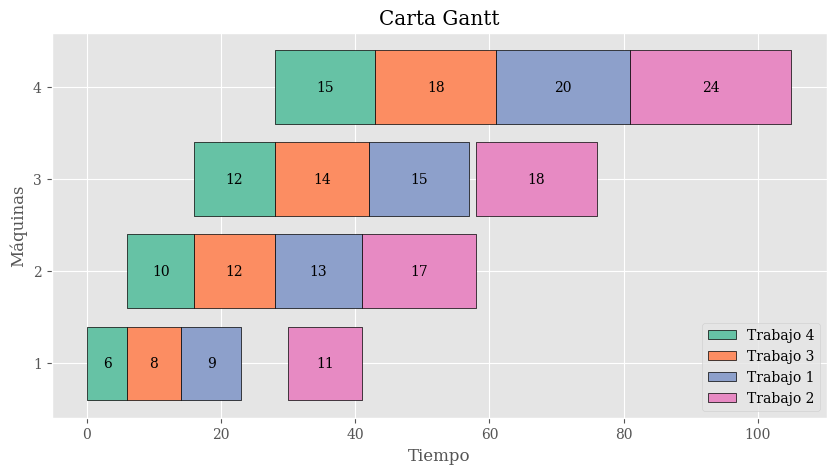

In [158]:
# Obtener la secuencia de trabajos
secuencia = []
for i in range(N):
    for j in range(N):
        if pulp.value(Z[i][j]) == 1:
            secuencia.append([i, j])

# Ordenar la secuencia 
secuencia.sort(key=lambda x: x[1])

# Carta Gantt
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Carta Gantt')
ax.set_xlabel('Tiempo')
ax.set_ylabel('Máquinas')
ax.set_yticks(range(N))
ax.set_yticklabels(range(1, N + 1))
ax.grid(True)

for i in range(M):
    start_time = X[i][0].varValue
    for j in range(N):
        delay_time = 0 if j == 0 else X[i][j].varValue
        processing_time = T[i][secuencia[j][0]]
        ax.broken_barh([(start_time + delay_time, processing_time)], (i - 0.4, 0.8), facecolors=colores[j], edgecolor='black')
        ax.text(start_time + delay_time + processing_time / 2, i, str(processing_time), horizontalalignment='center', verticalalignment='center')
        start_time += processing_time

# Mostrar leyenda
ax.legend(["Trabajo "+str(i+1) for i,j in secuencia], loc='lower right')
plt.show()

## Modelo Cplex

In [159]:
wagner_model_cplex = Model(name='Wagner_Model_Cplex')

# Variables de decisión
X = wagner_model_cplex.integer_var_matrix(keys1=range(N), keys2=range(M), name="X")
Y = wagner_model_cplex.integer_var_matrix(keys1=range(N), keys2=range(M), name="Y")
Z = wagner_model_cplex.binary_var_matrix(keys1=range(N), keys2=range(N), name="Z")

# Función objetivo (Restricción 5)
wagner_model_cplex.minimize(wagner_model_cplex.sum(T[M-1][i] for i in range(N)) + wagner_model_cplex.sum(X[M-1, p] for p in range(N)))

# Restricción 1
for i in range(N):
    wagner_model_cplex.add_constraint(wagner_model_cplex.sum(Z[i, j] for j in range(N)) == 1)

# Restricción 2
for j in range(N):
    wagner_model_cplex.add_constraint(wagner_model_cplex.sum(Z[i, j] for i in range(N)) == 1)

# Restricción 3
for j in range(N - 1):
    for r in range(M - 1):
        wagner_model_cplex.add_constraint(wagner_model_cplex.sum(T[r][i] * Z[i, j+1] for i in range(N)) - wagner_model_cplex.sum(T[r+1][i] * Z[i, j] for i in range(N)) + X[r, j+1] - X[r+1, j+1] + Y[r, j+1] - Y[r, j] == 0)

# Restricción 4
for r in range(M - 1):
    wagner_model_cplex.add_constraint(wagner_model_cplex.sum(T[r][i] * Z[i, 0] for i in range(N)) + X[r, 0] - X[r+1, 0] + Y[r, 0] == 0)

# Resolver

start_time = time.time()
wagner_model_cplex.solve()
end_time = time.time()
elapsed_time = end_time - start_time

# Guardar resultados modelo, solver, valor y tiempo
resultados.append(["Wagner","CPLEX", wagner_model_cplex.objective_value, elapsed_time])

# Imprimir resultados
print("Status:", wagner_model_cplex.get_solve_status())
print("Función objetivo =", wagner_model_cplex.objective_value)

Status: JobSolveStatus.OPTIMAL_SOLUTION
Función objetivo = 105.0


### Carta Gantt

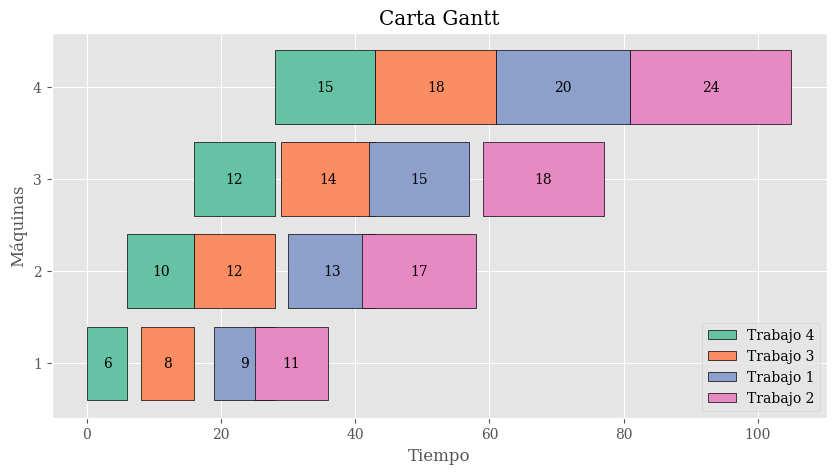

In [160]:
# Obtener la secuencia de trabajos
secuencia = []
for i in range(N):
    for j in range(N):
        if wagner_model_cplex.solution.get_value(Z[i, j]) == 1:
            secuencia.append([i, j])

# Ordenar la secuencia 
secuencia.sort(key=lambda x: x[1])

# Carta Gantt
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Carta Gantt')
ax.set_xlabel('Tiempo')
ax.set_ylabel('Máquinas')
ax.set_yticks(range(N))
ax.set_yticklabels(range(1, N + 1))
ax.grid(True)

for i in range(M):
    start_time = wagner_model_cplex.solution.get_value(X[i, 0])
    for j in range(N):
        delay_time = 0 if j == 0 else wagner_model_cplex.solution.get_value(X[i, j])
        processing_time = T[i][secuencia[j][0]]
        ax.broken_barh([(start_time + delay_time, processing_time)], (i - 0.4, 0.8), facecolors=colores[j], edgecolor='black')
        ax.text(start_time + delay_time + processing_time / 2, i, str(processing_time), horizontalalignment='center', verticalalignment='center')
        start_time += processing_time

# Mostrar leyenda
ax.legend(["Trabajo "+str(i+1) for i,j in secuencia], loc='lower right')
plt.show()

## Modelo Gurobi

In [161]:
wagner_model_gurobi = gp.Model("Wagner_Model_Gurobi")

# Variables de decisión
X = wagner_model_gurobi.addVars(range(N), range(M), lb=0, vtype=GRB.INTEGER, name="X")
Y = wagner_model_gurobi.addVars(range(N), range(M), lb=0, vtype=GRB.INTEGER, name="Y")
Z = wagner_model_gurobi.addVars(range(N), range(N), vtype=GRB.BINARY, name="Z")

# Función objetivo (Restricción 5)
wagner_model_gurobi.setObjective(gp.quicksum(T[M-1][i] for i in range(N)) + gp.quicksum(X[M-1, p] for p in range(N)), GRB.MINIMIZE)

# Restricción 1
for i in range(N):
    wagner_model_gurobi.addConstr(gp.quicksum(Z[i, j] for j in range(N)) == 1)

# Restricción 2
for j in range(N):
    wagner_model_gurobi.addConstr(gp.quicksum(Z[i, j] for i in range(N)) == 1)

# Restricción 3
for j in range(N - 1):
    for r in range(M - 1):
        wagner_model_gurobi.addConstr(gp.quicksum(T[r][i] * Z[i, j+1] for i in range(N)) - gp.quicksum(T[r+1][i] * Z[i, j] for i in range(N)) + X[r, j+1] - X[r+1, j+1] + Y[r, j+1] - Y[r, j] == 0)

# Restricción 4
for r in range(M - 1):
    wagner_model_gurobi.addConstr(gp.quicksum(T[r][i] * Z[i, 0] for i in range(N)) + X[r, 0] - X[r+1, 0] + Y[r, 0] == 0)

# Resolver sin mostrar output
wagner_model_gurobi.Params.OutputFlag = 0

start_time = time.time()
wagner_model_gurobi.optimize()
end_time = time.time()
elapsed_time = end_time - start_time

# Guardar resultados modelo, solver, valor y tiempo
resultados.append(["Wagner","Gurobi", wagner_model_gurobi.objVal, elapsed_time])

# Imprimir resultados
print("Status:", wagner_model_gurobi.Status)
print("Función objetivo =", wagner_model_gurobi.ObjVal)

Status: 2
Función objetivo = 105.0


### Carta Gantt

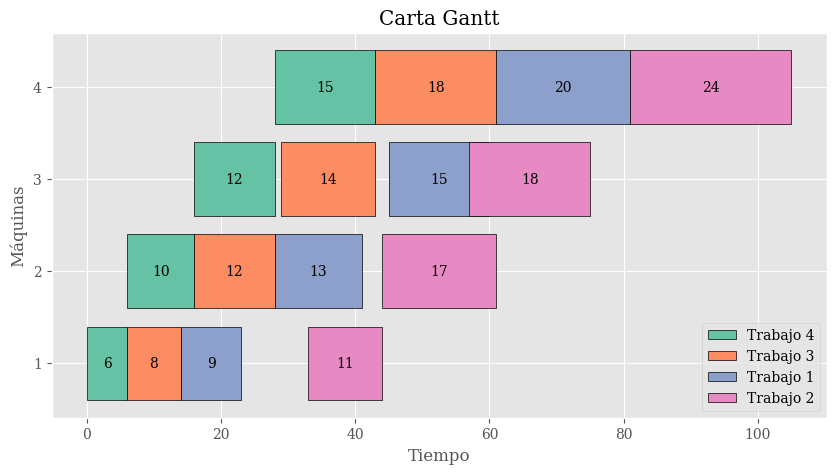

In [162]:
# Obtener la secuencia de trabajos
secuencia = []
for i in range(N):
    for j in range(N):
        if Z[i, j].x == 1:
            secuencia.append([i, j])

# Ordenar la secuencia 
secuencia.sort(key=lambda x: x[1])

# Carta Gantt
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Carta Gantt')
ax.set_xlabel('Tiempo')
ax.set_ylabel('Máquinas')
ax.set_yticks(range(N))
ax.set_yticklabels(range(1, N + 1))
ax.grid(True)

for i in range(M):
    start_time = X[i, 0].x
    for j in range(N):
        delay_time = 0 if j == 0 else X[i, j].x
        processing_time = T[i][secuencia[j][0]]
        ax.broken_barh([(start_time + delay_time, processing_time)], (i - 0.4, 0.8), facecolors=colores[j], edgecolor='black')
        ax.text(start_time + delay_time + processing_time / 2, i, str(processing_time), horizontalalignment='center', verticalalignment='center')
        start_time += processing_time

# Mostrar leyenda
ax.legend(["Trabajo "+str(i+1) for i,j in secuencia], loc='lower right')
plt.show()

# Formulación Wilson

## Modelo Matemático

$$
\begin{gather}
    \text{Minimizar } C_{max} = B_{MN} + \sum_{i=1}^{N}{T_{Mi}Z_{iN}}\notag\\
    \text{s.a } \sum_{j=1}^{N}{Z_{ij}} = 1; \:\:\: (1 \leq i \leq N)\\
    \sum_{i=1}^{N}{Z_{ij}} = 1; \:\:\: (1 \leq j \leq N)\\
    B_{1j} + \sum_{i=1}^{N}{T_{1i}Z_{ij}} = B_{1,j+1} \:\:\: (1 \leq j \leq N-1)\\
    B_{11} = 0\\
    B_{r1} + \sum_{i=1}^{N}{T_{ri}Z_{1i}} = B_{r+1,1} \:\:\: (1 \leq r \leq M-1)\\
    B_{rj} + \sum_{i=1}^{N}{T_{ri}Z_{ij}} \leq B_{r+1,j} \:\:\: (1 \leq r \leq M-1; 2 \leq j \leq N)\\
    B_{rj} + \sum_{i=1}^{N}{T_{ri}Z_{ij}} \leq B_{r,j+1} \:\:\: (2 \leq r \leq M; 1 \leq j \leq N-1)\\
\end{gather}
$$

## Modelo PulP

In [163]:
wilson_model_pulp = pulp.LpProblem("Wilson_Model_Pulp",pulp.LpMinimize) # Problema de minimización

# Variables de decision
B = pulp.LpVariable.dicts("B",(range(M),range(N)),lowBound=0, cat=pulp.LpInteger)
Z = pulp.LpVariable.dicts("Z",(range(N),range(N)),lowBound=0, cat=pulp.LpBinary)

# Funcion objetivo
wilson_model_pulp += B[M-1][N-1] + pulp.lpSum(T[M-1][i]*Z[i][N-1] for i in range(N))

# Restriccion 1
for i in range(N):
    wilson_model_pulp += pulp.lpSum(Z[i][j] for j in range(N)) == 1

# Restriccion 2
for j in range(N):
    wilson_model_pulp += pulp.lpSum(Z[i][j] for i in range(N)) == 1

# Restriccion 3
for j in range(N - 1):
    wilson_model_pulp += B[0][j] + pulp.lpSum(T[0][i]*Z[i][j] for i in range(N)) == B[0][j+1]

# Restriccion 4
wilson_model_pulp += B[0][0] == 0

# Restriccion 5
for r in range(M - 1):
    wilson_model_pulp += B[r][0] + pulp.lpSum(T[r][i]*Z[i][0] for i in range(N)) == B[r+1][0]

# Restriccion 6
for r in range(M - 1):
    for j in range(1,N):
        wilson_model_pulp += B[r][j] + pulp.lpSum(T[r][i]*Z[i][j] for i in range(N)) <= B[r+1][j]

# Restriction 7
for r in range(1,M):
    for j in range(N - 1):
        wilson_model_pulp += B[r][j] + pulp.lpSum(T[r][i]*Z[i][j] for i in range(N)) <= B[r][j+1]

# Resolver
start_time = time.time()
wilson_model_pulp.solve(pulp.PULP_CBC_CMD(msg=False))
end_time = time.time()
elapsed_time = end_time - start_time

# Guardar resultados modelo, solver, valor y tiempo
resultados.append(["Wilson","PuLP", pulp.value(wilson_model_pulp.objective), elapsed_time])

# Imprimir resultados
print("Status:", pulp.LpStatus[wilson_model_pulp.status])
print("Funcion objetivo = ", pulp.value(wilson_model_pulp.objective))

Status: Optimal
Funcion objetivo =  105.0


### Carta Gantt

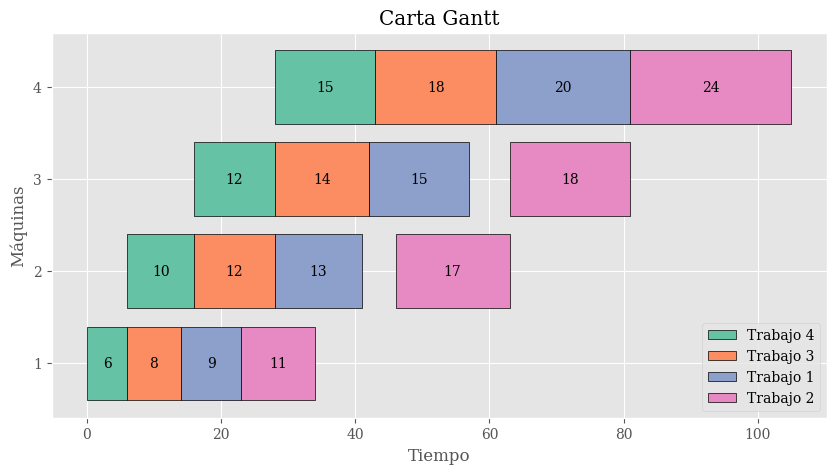

In [164]:
# Obtener la secuencia de trabajos
secuencia = []
for i in range(N):
    for j in range(N):
        if pulp.value(Z[i][j]) == 1:
            secuencia.append([i, j])

# Ordenar la secuencia 
secuencia.sort(key=lambda x: x[1])

# Carta Gantt
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Carta Gantt')
ax.set_xlabel('Tiempo')
ax.set_ylabel('Máquinas')
ax.set_yticks(range(N))
ax.set_yticklabels(range(1, N + 1))
ax.grid(True)

for i in range(N):
    for j in range(M):
        start_time = B[i][j].varValue
        processing_time = T[i][secuencia[j][0]]
        ax.broken_barh([(start_time, processing_time)], (i - 0.4, 0.8), facecolors=colores[j], edgecolor='black')
        ax.text(start_time + processing_time / 2, i, str(processing_time), horizontalalignment='center', verticalalignment='center')

# Mostrar leyenda
ax.legend(["Trabajo "+str(i+1) for i,j in secuencia], loc='lower right')
plt.show()

## Modelo Cplex

In [165]:
wilson_model_cplex = Model(name='Wilson_Model_Cplex')

# Variables de decisión
B = wilson_model_cplex.integer_var_matrix(keys1=range(M), keys2=range(N), name="B")
Z = wilson_model_cplex.binary_var_matrix(keys1=range(N), keys2=range(N), name="Z")

# Función objetivo
wilson_model_cplex.minimize(B[M-1, N-1] + wilson_model_cplex.sum(T[M-1][i]*Z[i, N-1] for i in range(N)))

# Restricción 1
for i in range(N):
    wilson_model_cplex.add_constraint(wilson_model_cplex.sum(Z[i, j] for j in range(N)) == 1)

# Restricción 2
for j in range(N):
    wilson_model_cplex.add_constraint(wilson_model_cplex.sum(Z[i, j] for i in range(N)) == 1)

# Restricción 3
for j in range(N - 1):
    wilson_model_cplex.add_constraint(B[0, j] + wilson_model_cplex.sum(T[0][i]*Z[i, j] for i in range(N)) == B[0, j+1])

# Restricción 4
wilson_model_cplex.add_constraint(B[0, 0] == 0)

# Restricción 5
for r in range(M - 1):
    wilson_model_cplex.add_constraint(B[r, 0] + wilson_model_cplex.sum(T[r][i]*Z[i, 0] for i in range(N)) == B[r+1, 0])

# Restricción 6
for r in range(M - 1):
    for j in range(1,N):
        wilson_model_cplex.add_constraint(B[r, j] + wilson_model_cplex.sum(T[r][i]*Z[i, j] for i in range(N)) <= B[r+1, j])

# Restricción 7
for r in range(1,M):
    for j in range(N - 1):
        wilson_model_cplex.add_constraint(B[r, j] + wilson_model_cplex.sum(T[r][i]*Z[i, j] for i in range(N)) <= B[r, j+1])

# Resolver
start_time = time.time()
wilson_model_cplex.solve()
end_time = time.time()
elapsed_time = end_time - start_time

# Guardar resultados modelo, solver, valor y tiempo
resultados.append(["Wilson","CPLEX", wilson_model_cplex.objective_value, elapsed_time])

# Imprimir resultados
print("Status:", wilson_model_cplex.get_solve_status())
print("Función objetivo =", wilson_model_cplex.objective_value)

Status: JobSolveStatus.OPTIMAL_SOLUTION
Función objetivo = 105.0


### Carta Gantt

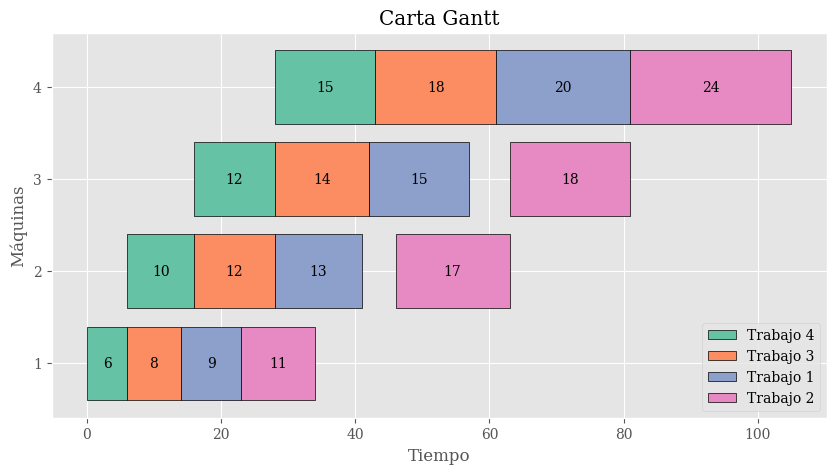

In [166]:
# Obtener la secuencia de trabajos
secuencia = []
for i in range(N):
    for j in range(N):
        if wilson_model_cplex.solution.get_value(Z[i, j]) == 1:
            secuencia.append([i, j])

# Ordenar la secuencia 
secuencia.sort(key=lambda x: x[1])

# Carta Gantt
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Carta Gantt')
ax.set_xlabel('Tiempo')
ax.set_ylabel('Máquinas')
ax.set_yticks(range(N))
ax.set_yticklabels(range(1, N + 1))
ax.grid(True)

for i in range(N):
    for j in range(M):
        start_time = wilson_model_cplex.solution.get_value(B[i, j])
        processing_time = T[i][secuencia[j][0]]
        ax.broken_barh([(start_time, processing_time)], (i - 0.4, 0.8), facecolors=colores[j], edgecolor='black')
        ax.text(start_time + processing_time / 2, i, str(processing_time), horizontalalignment='center', verticalalignment='center')

# Mostrar leyenda
ax.legend(["Trabajo "+str(i+1) for i,j in secuencia], loc='lower right')
plt.show()

## Modelo Gurobi

In [167]:
wilson_model_gurobi = gp.Model("Wilson_Model_Gurobi")

# Variables de decisión
B = wilson_model_gurobi.addVars(range(M), range(N), lb=0, vtype=GRB.INTEGER, name="B")
Z = wilson_model_gurobi.addVars(range(N), range(N), vtype=GRB.BINARY, name="Z")

# Función objetivo
wilson_model_gurobi.setObjective(B[M-1, N-1] + gp.quicksum(T[M-1][i]*Z[i, N-1] for i in range(N)), GRB.MINIMIZE)

# Restricción 1
for i in range(N):
    wilson_model_gurobi.addConstr(gp.quicksum(Z[i, j] for j in range(N)) == 1)

# Restricción 2
for j in range(N):
    wilson_model_gurobi.addConstr(gp.quicksum(Z[i, j] for i in range(N)) == 1)

# Restricción 3
for j in range(N - 1):
    wilson_model_gurobi.addConstr(B[0, j] + gp.quicksum(T[0][i]*Z[i, j] for i in range(N)) == B[0, j+1])

# Restricción 4
wilson_model_gurobi.addConstr(B[0, 0] == 0)

# Restricción 5
for r in range(M - 1):
    wilson_model_gurobi.addConstr(B[r, 0] + gp.quicksum(T[r][i]*Z[i, 0] for i in range(N)) == B[r+1, 0])

# Restricción 6
for r in range(M - 1):
    for j in range(1,N):
        wilson_model_gurobi.addConstr(B[r, j] + gp.quicksum(T[r][i]*Z[i, j] for i in range(N)) <= B[r+1, j])

# Restricción 7
for r in range(1,M):
    for j in range(N - 1):
        wilson_model_gurobi.addConstr(B[r, j] + gp.quicksum(T[r][i]*Z[i, j] for i in range(N)) <= B[r, j+1])

# Resolver
wilson_model_gurobi.Params.OutputFlag = 0
start_time = time.time()
wilson_model_gurobi.optimize()
end_time = time.time()
elapsed_time = end_time - start_time

# Guardar resultados modelo, solver, valor y tiempo
resultados.append(["Wilson","Gurobi", wilson_model_gurobi.objVal, elapsed_time])

# Imprimir resultados
print("Status:", wilson_model_gurobi.Status)
print("Función objetivo =", wilson_model_gurobi.ObjVal)

Status: 2
Función objetivo = 105.0


### Carta Gantt

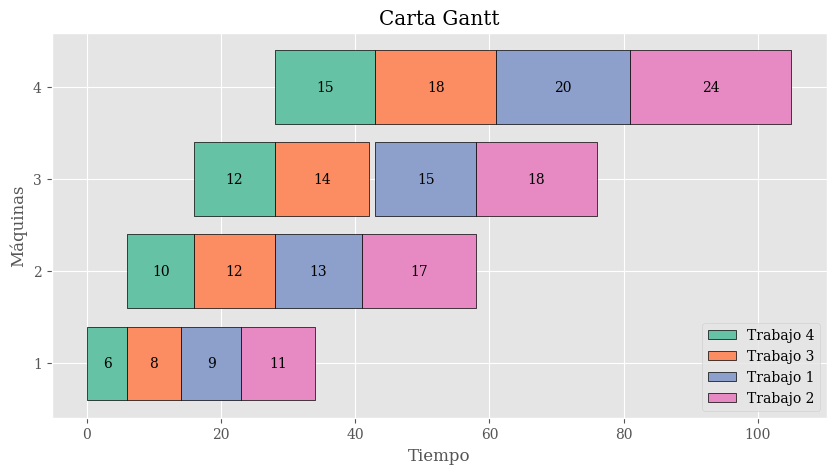

In [168]:
# Obtener la secuencia de trabajos
secuencia = []
for i in range(N):
    for j in range(N):
        if Z[i, j].x == 1:
            secuencia.append([i, j])

# Ordenar la secuencia 
secuencia.sort(key=lambda x: x[1])

# Carta Gantt
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Carta Gantt')
ax.set_xlabel('Tiempo')
ax.set_ylabel('Máquinas')
ax.set_yticks(range(N))
ax.set_yticklabels(range(1, N + 1))
ax.grid(True)

for i in range(N):
    for j in range(M):
        start_time = B[i, j].x
        processing_time = T[i][secuencia[j][0]]
        ax.broken_barh([(start_time, processing_time)], (i - 0.4, 0.8), facecolors=colores[j], edgecolor='black')
        ax.text(start_time + processing_time / 2, i, str(processing_time), horizontalalignment='center', verticalalignment='center')

# Mostrar leyenda
ax.legend(["Trabajo "+str(i+1) for i,j in secuencia], loc='lower right')
plt.show()

# Formulación Manne

## Modelo Matemático

$$
\begin{gather}
    \text{Minimizar } C_{max} \notag\\
    \text{s.a}\:\: C_{1i} \geq T_{1i} \:\:\: (1 \leq i \leq N)\\
    C_{ri} - C_{r-1,i} \geq T_{ri} \:\:\: (2 \leq r \leq M; 1 \leq i \leq N)\\
    C_{ri} - C_{rk} + PD_{ik} \geq T_{ri} \:\:\: (1 \leq r \leq M; 1 \leq i < k \leq N)\\
    C_{ri} - C_{rk} + PD_{ik} \leq P - T_{rk} \:\:\: (1 \leq r \leq M; 1 \leq i < k \leq N)\\
    C_{max} \geq C_{Mi} \:\:\: (1 \leq i \leq N)\\
    \text{Con } P \text{ definida como una constante muy grande} \notag
\end{gather}
$$


## Modelo PulP

In [169]:
manne_model_pulp = pulp.LpProblem("Manne_Model_Pulp",pulp.LpMinimize) # Problema de minimización

# Variables de decision
C = pulp.LpVariable.dicts("C",(range(M),range(N)),lowBound=0, cat=pulp.LpInteger)
D = pulp.LpVariable.dicts("D",(range(N),range(N)),lowBound=0, cat=pulp.LpBinary)
Cmax = pulp.LpVariable("Cmax",lowBound=0, cat=pulp.LpInteger)
P = 1000 # P una constante grande

# Funcion objetivo
manne_model_pulp += Cmax

# Restriccion 1
for i in range(N):
    manne_model_pulp += C[0][i] >= T[0][i]

# Restriccion 2
for r in range(1,M):
    for i in range(N):
        manne_model_pulp += C[r][i] - C[r-1][i] >= T[r][i]

# Restriccion 3
for r in range(M):
    for i in range(N):
        for k in range(i + 1, N):  # Ajustar el rango para i < k
            manne_model_pulp += C[r][i] - C[r][k] + P * D[i][k] >= T[r][i]
    
# Restriccion 4
for r in range(M):
    for i in range(N):
        for k in range(i + 1, N):  # Ajustar el rango para i < k
            manne_model_pulp += C[r][i] - C[r][k] + P * D[i][k] <= P - T[r][k]

# Restriccion 5
for i in range(N):
    manne_model_pulp += Cmax >= C[M-1][i]

# Resolver
start_time = time.time()
manne_model_pulp.solve(pulp.PULP_CBC_CMD(msg=False))
end_time = time.time()
elapsed_time = end_time - start_time

# Guardar resultados modelo, solver, valor y tiempo
resultados.append(["Manne","PuLP", pulp.value(manne_model_pulp.objective), elapsed_time])

# Imprimir resultados
print("Status:", pulp.LpStatus[manne_model_pulp.status])
print("Funcion objetivo = ", pulp.value(manne_model_pulp.objective))

Status: Optimal
Funcion objetivo =  105.0


### Carta Gantt

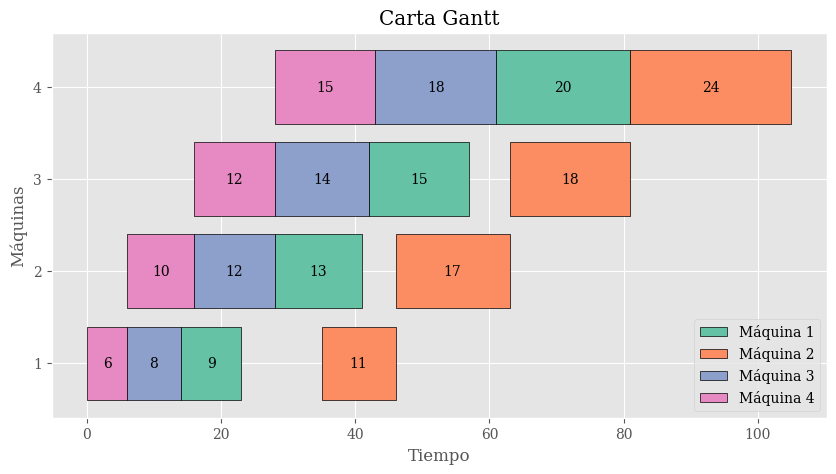

In [170]:
# Carta Gantt en base a los tiempos de termino C
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Carta Gantt')
ax.set_xlabel('Tiempo')
ax.set_ylabel('Máquinas')
ax.set_yticks(range(N))
ax.set_yticklabels(range(1, N + 1))
ax.grid(True)

for i in range(N):
    for j in range(M):
        start_time = C[i][j].varValue - T[i][j]
        processing_time = T[i][j]
        ax.broken_barh([(start_time, processing_time)], (i - 0.4, 0.8), facecolors=colores[j], edgecolor='black')
        ax.text(start_time + processing_time / 2, i, str(processing_time), horizontalalignment='center', verticalalignment='center')

# Mostrar leyenda
ax.legend(["Máquina "+str(i+1) for i in range(M)], loc='lower right')

plt.show()

## Modelo Cplex

In [171]:
manne_model_cplex = Model(name='Manne_Model_Cplex')

# Variables de decisión
C = manne_model_cplex.integer_var_matrix(keys1=range(M), keys2=range(N), name="C")
D = manne_model_cplex.binary_var_matrix(keys1=range(N), keys2=range(N), name="D")
Cmax = manne_model_cplex.integer_var(name="Cmax")
P = 1000 # P una constante grande

# Función objetivo
manne_model_cplex.minimize(Cmax)

# Restricción 1
for i in range(N):
    manne_model_cplex.add_constraint(C[0,i] >= T[0][i])

# Restricción 2
for r in range(1,M):
    for i in range(N):
        manne_model_cplex.add_constraint(C[r,i] - C[r-1,i] >= T[r][i])

# Restricción 3
for r in range(M):
    for i in range(N):
        for k in range(i + 1, N):  # Ajustar el rango para i < k
            manne_model_cplex.add_constraint(C[r,i] - C[r,k] + P * D[i,k] >= T[r][i])

# Restricción 4
for r in range(M):
    for i in range(N):
        for k in range(i + 1, N):  # Ajustar el rango para i < k
            manne_model_cplex.add_constraint(C[r,i] - C[r,k] + P * D[i,k] <= P - T[r][k])

# Restricción 5
for i in range(N):
    manne_model_cplex.add_constraint(Cmax >= C[M-1,i])

# Resolver
start_time = time.time()
manne_model_cplex.solve()
end_time = time.time()
elapsed_time = end_time - start_time

# Guardar resultados modelo, solver, valor y tiempo
resultados.append(["Manne","CPLEX", manne_model_cplex.objective_value, elapsed_time])

# Imprimir resultados
print("Status:", manne_model_cplex.get_solve_status())
print("Función objetivo =", manne_model_cplex.objective_value)

Status: JobSolveStatus.OPTIMAL_SOLUTION
Función objetivo = 105.0


### Carta Gantt

In [172]:
print("hola")

hola


## Modelo Gurobi

In [173]:
manne_model_gurobi = gp.Model("Manne_Model_Gurobi")

# Variables de decisión
C = manne_model_gurobi.addVars(range(M), range(N), lb=0, vtype=GRB.INTEGER, name="C")
D = manne_model_gurobi.addVars(range(N), range(N), vtype=GRB.BINARY, name="D")
Cmax = manne_model_gurobi.addVar(lb=0, vtype=GRB.INTEGER, name="Cmax")
P = 1000 # P una constante grande

# Función objetivo
manne_model_gurobi.setObjective(Cmax, GRB.MINIMIZE)

# Restricción 1
for i in range(N):
    manne_model_gurobi.addConstr(C[0,i] >= T[0][i])

# Restricción 2
for r in range(1,M):
    for i in range(N):
        manne_model_gurobi.addConstr(C[r,i] - C[r-1,i] >= T[r][i])

# Restricción 3
for r in range(M):
    for i in range(N):
        for k in range(i + 1, N):  # Ajustar el rango para i < k
            manne_model_gurobi.addConstr(C[r,i] - C[r,k] + P * D[i,k] >= T[r][i])

# Restricción 4
for r in range(M):
    for i in range(N):
        for k in range(i + 1, N):  # Ajustar el rango para i < k
            manne_model_gurobi.addConstr(C[r,i] - C[r,k] + P * D[i,k] <= P - T[r][k])

# Restricción 5
for i in range(N):
    manne_model_gurobi.addConstr(Cmax >= C[M-1,i])

# Resolver
manne_model_gurobi.Params.OutputFlag = 0
start_time = time.time()
manne_model_gurobi.optimize()
end_time = time.time()
elapsed_time = end_time - start_time

# Guardar resultados modelo, solver, valor y tiempo
resultados.append(["Manne","Gurobi", manne_model_gurobi.objVal, elapsed_time])

# Imprimir resultados
print("Status:", manne_model_gurobi.Status)
print("Función objetivo =", manne_model_gurobi.ObjVal)

Status: 2
Función objetivo = 105.0


### Carta Gantt

In [174]:
print("hola")

hola


# Formulación Liao–You

## Modelo Matemático

$$
\begin{gather}
    \text{Minimizar } C_{max} \notag\\
    \text{s.a}\:\: S_{ri} + T_{ri} \leq S_{r+1,i} \:\:\: (1 \leq r \leq M-1; 1 \leq i \leq N)\\
    S_{ri} - S_{rk} + PD_{ik} - T_{rk} = q_{rik} \:\:\: (1 \leq r \leq M; 1 \leq i < k \leq N)\\
    P - T_{ri} - T_{rk} \geq q_{rik} \:\:\: (1 \leq r \leq M; 1 \leq i < k \leq N)\\
    C_{max} \geq S_{Mi} + T_{Mi} \:\:\: (1 \leq i \leq N)\\
    \text{Con } q_{rik} \text{ una variable para representar algebraicamente la relación de precedencia entre los trabajos } i \text{ y } k \text{ en la máquina } r \notag
\end{gather}
$$

## Modelo PulP

In [175]:
liao_you_model_pulp = pulp.LpProblem("Liao-You_Model_Pulp",pulp.LpMinimize) # Problema de minimización

# Variables de decision
S = pulp.LpVariable.dicts("S",(range(M),range(N)),lowBound=0, cat=pulp.LpInteger)
D = pulp.LpVariable.dicts("D",(range(N),range(N)),lowBound=0, cat=pulp.LpBinary)
Cmax = pulp.LpVariable("Cmax",lowBound=0, cat=pulp.LpInteger)
q = pulp.LpVariable.dicts("q", (range(M), range(N), range(N)), lowBound=0, cat=pulp.LpInteger)
P = 1000 # P una constante grande

# Funcion objetivo
liao_you_model_pulp += Cmax

# Restriccion 1
for r in range(M-1):
    for i in range(N):
        liao_you_model_pulp += S[r][i] + T[r][i] <= S[r+1][i]

# Restriccion 2
for r in range(M):
    for i in range(N):
        for k in range(i + 1, N):  # Ajustar el rango para i < k
            liao_you_model_pulp += S[r][i] - S[r][k] + P * D[i][k] - T[r][k] == q[r][i][k]

# Restriccion 3
for r in range(M):
    for i in range(N):
        for k in range(i + 1, N):  # Ajustar el rango para i < k
            liao_you_model_pulp += q[r][i][k] <= P - T[r][i] - T[r][k] 

# Restriccion 4
for i in range(N):
    liao_you_model_pulp += Cmax >= S[M-1][i] + T[M-1][i]

# Resolver
start_time = time.time()
liao_you_model_pulp.solve(pulp.PULP_CBC_CMD(msg=False))
end_time = time.time()
elapsed_time = end_time - start_time

# Guardar resultados modelo, solver, valor y tiempo
resultados.append(["Liao-You","PuLP", pulp.value(liao_you_model_pulp.objective), elapsed_time])

# Imprimir resultados
print("Status:", pulp.LpStatus[liao_you_model_pulp.status])
print("Funcion objetivo = ", pulp.value(liao_you_model_pulp.objective))

Status: Optimal
Funcion objetivo =  105.0


### Carta Gantt

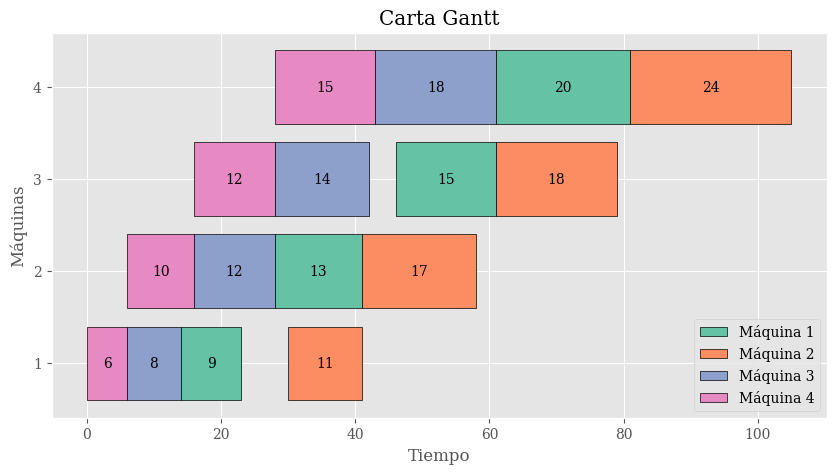

In [176]:
# Carta Gantt
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Carta Gantt')
ax.set_xlabel('Tiempo')
ax.set_ylabel('Máquinas')
ax.set_yticks(range(N))
ax.set_yticklabels(range(1, N + 1))
ax.grid(True)

for i in range(N):
    for j in range(M):
        start_time = S[i][j].varValue
        processing_time = T[i][j]
        ax.broken_barh([(start_time, processing_time)], (i - 0.4, 0.8), facecolors=colores[j], edgecolor='black')
        ax.text(start_time + processing_time / 2, i, str(processing_time), horizontalalignment='center', verticalalignment='center')

# Mostrar leyenda
ax.legend(["Máquina "+str(i+1) for i in range(M)], loc='lower right')

plt.show()

## Modelo Cplex

In [177]:
liao_you_model_cplex = Model(name='Liao-You_Model_Cplex')

# Variables de decisión
S = liao_you_model_cplex.integer_var_matrix(keys1=range(M), keys2=range(N), name="S")
D = liao_you_model_cplex.binary_var_matrix(keys1=range(N), keys2=range(N), name="D")
Cmax = liao_you_model_cplex.integer_var(name="Cmax")
q = liao_you_model_cplex.integer_var_cube(keys1=range(M), keys2=range(N), keys3=range(N), name="q")
P = 1000 # P una constante grande

# Función objetivo
liao_you_model_cplex.minimize(Cmax)

# Restricción 1
for r in range(M-1):
    for i in range(N):
        liao_you_model_cplex.add_constraint(S[r,i] + T[r][i] <= S[r+1,i])

# Restricción 2
for r in range(M):
    for i in range(N):
        for k in range(i + 1, N):  # Ajustar el rango para i < k
            liao_you_model_cplex.add_constraint(S[r,i] - S[r,k] + P * D[i,k] - T[r][k] == q[r,i,k])

# Restricción 3
for r in range(M):
    for i in range(N):
        for k in range(i + 1, N):  # Ajustar el rango para i < k
            liao_you_model_cplex.add_constraint(q[r,i,k] <= P - T[r][i] - T[r][k])

# Restricción 4
for i in range(N):
    liao_you_model_cplex.add_constraint(Cmax >= S[M-1,i] + T[M-1][i])

# Resolver
start_time = time.time()
liao_you_model_cplex.solve()
end_time = time.time()
elapsed_time = end_time - start_time

# Guardar resultados modelo, solver, valor y tiempo
resultados.append(["Liao-You","CPLEX", liao_you_model_cplex.objective_value, elapsed_time])

# Imprimir resultados
print("Status:", liao_you_model_cplex.get_solve_status())
print("Función objetivo =", liao_you_model_cplex.objective_value)

Status: JobSolveStatus.OPTIMAL_SOLUTION
Función objetivo = 105.0


### Carta Gantt

In [178]:
print("hola")

hola


## Modelo Gurobi

In [179]:
liao_you_model_gurobi = gp.Model("Liao-You_Model_Gurobi")

# Variables de decisión
S = liao_you_model_gurobi.addVars(range(M), range(N), lb=0, vtype=GRB.INTEGER, name="S")
D = liao_you_model_gurobi.addVars(range(N), range(N), vtype=GRB.BINARY, name="D")
Cmax = liao_you_model_gurobi.addVar(lb=0, vtype=GRB.INTEGER, name="Cmax")
q = liao_you_model_gurobi.addVars(range(M), range(N), range(N), lb=0, vtype=GRB.INTEGER, name="q")
P = 1000 # P una constante grande

# Función objetivo
liao_you_model_gurobi.setObjective(Cmax, GRB.MINIMIZE)

# Restricción 1
for r in range(M-1):
    for i in range(N):
        liao_you_model_gurobi.addConstr(S[r,i] + T[r][i] <= S[r+1,i])

# Restricción 2
for r in range(M):
    for i in range(N):
        for k in range(i + 1, N):  # Ajustar el rango para i < k
            liao_you_model_gurobi.addConstr(S[r,i] - S[r,k] + P * D[i,k] - T[r][k] == q[r,i,k])

# Restricción 3
for r in range(M):
    for i in range(N):
        for k in range(i + 1, N):  # Ajustar el rango para i < k
            liao_you_model_gurobi.addConstr(q[r,i,k] <= P - T[r][i] - T[r][k])

# Restricción 4
for i in range(N):
    liao_you_model_gurobi.addConstr(Cmax >= S[M-1,i] + T[M-1][i])

# Resolver
start_time = time.time()
liao_you_model_gurobi.Params.OutputFlag = 0
liao_you_model_gurobi.optimize()
end_time = time.time()
elapsed_time = end_time - start_time

# Guardar resultados modelo, solver, valor y tiempo
resultados.append(["Liao-You","Gurobi", liao_you_model_gurobi.objVal, elapsed_time])

# Imprimir resultados
print("Status:", liao_you_model_gurobi.Status)
print("Función objetivo =", liao_you_model_gurobi.ObjVal)

Status: 2
Función objetivo = 105.0


### Carta Gantt

In [180]:
print("hola")

hola


# Comparación de Modelos

In [181]:
# Tabla con los resultados usando display e indice desde 1
df = pd.DataFrame(resultados, columns=["Modelo", "Solver", "Valor", "Tiempo"])
df.index = df.index + 1
display(df)

,Modelo,Solver,Valor,Tiempo
1,Wagner,PuLP,105.0,0.208305
2,Wagner,CPLEX,105.0,0.004933
3,Wagner,Gurobi,105.0,0.048380
4,Wilson,PuLP,105.0,0.017977
5,Wilson,CPLEX,105.0,0.003932
6,Wilson,Gurobi,105.0,0.021280
7,Manne,PuLP,105.0,0.329150
8,Manne,CPLEX,105.0,0.011696
9,Manne,Gurobi,105.0,0.001480
10,Liao-You,PuLP,105.0,0.235140


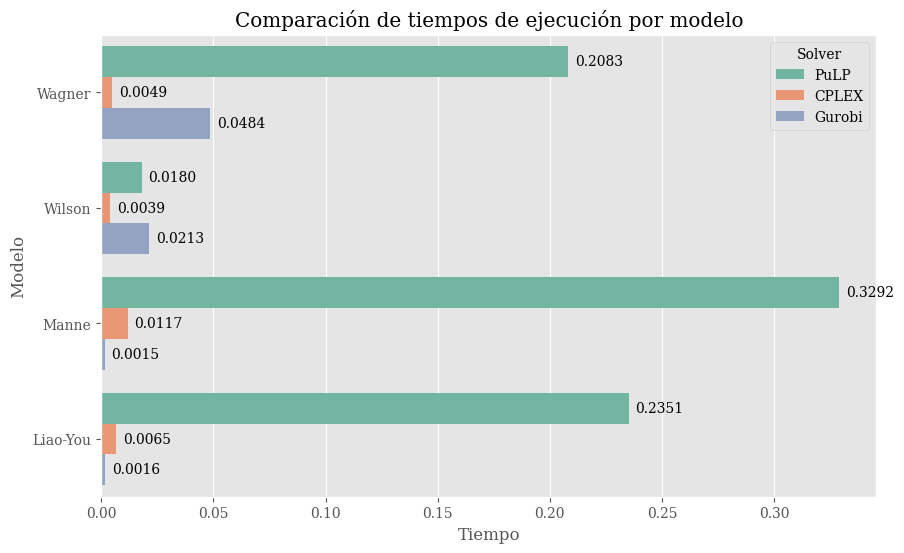

In [182]:
# Crear una figura
fig, ax = plt.subplots(figsize=(10, 6))

# Crear barras horizontales agrupadas por modelo
sns.barplot(x="Tiempo", y="Modelo", hue="Solver", data=df, ax=ax, palette="Set2")

# Agregar etiquetas y leyenda
ax.set_xlabel('Tiempo')
ax.set_ylabel('Modelo')
ax.set_title('Comparación de tiempos de ejecución por modelo')
ax.legend(title='Solver')

for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.annotate(f'{width:.4f}', (width, p.get_y() + p.get_height() / 2), ha='left', va='center', xytext=(5, 0), textcoords='offset points')

# Mostrar la figura
plt.show()



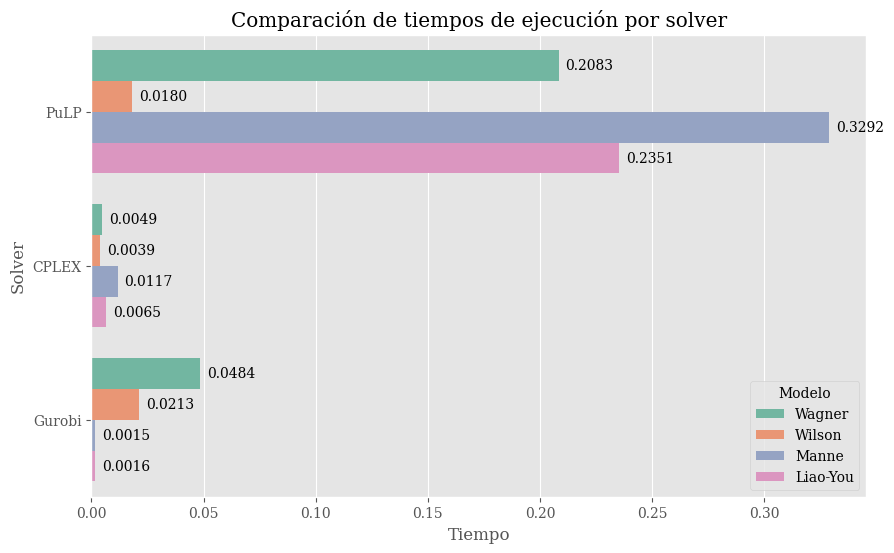

In [183]:
# Crear una figura
fig, ax = plt.subplots(figsize=(10, 6))

# Crear barras horizontales agrupadas por modelo
sns.barplot(x="Tiempo", y="Solver", hue="Modelo", data=df, ax=ax, palette="Set2")

# Agregar etiquetas y leyenda
ax.set_xlabel('Tiempo')
ax.set_ylabel('Solver')
ax.set_title('Comparación de tiempos de ejecución por solver')
ax.legend(title='Modelo')

for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.annotate(f'{width:.4f}', (width, p.get_y() + p.get_height() / 2), ha='left', va='center', xytext=(5, 0), textcoords='offset points')

# Mostrar la figura
plt.show()

# Conclusiones